# Práctico

En este práctico, correspondiente a la primera mitad de la materia, trabajaremos con un dataset extraído de Twitter. La idea es emplear los conceptos de grafos vistos en clase sobre un caso real de actualidad.

## Dataset

El dataset consiste en un conjunto de hilos de tweets, con un total de ~150000 tweets, extraídos entre Enero y Marzo de 2021. La temática de los mismos está referida a la vacunación contra el covid-19 en Argentina.

Pueden descargar el dataset del siguiente [link](https://drive.google.com/file/d/1X_qKsE8muAnom2tDX4sLlmBAO0Ikfe_G/view?usp=sharing).

### Campos

- **created_at:** Fecha del tweet
- **id_str:** ID del tweet
- **full_text:** Contenido del tweet
- **in_reply_to_status_id:** ID del tweet inmediatamente anterior en el hilo
- **in_reply_to_user_id:** Autor del tweet inmediatamente anterior en el hilo
- **user.id:** Autor del tweet
- **user_retweeters:** Lista de ID de usuarios que retweetearon el tweet
- **sentiment:** Etiquetado manual que indica el sentimiento o intención del tweet con respecto al tweet anterior en el hilo

## Configuración inicial

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#!pip install igraph
#!pip install cdlib

In [3]:
#Dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud
from cdlib import NodeClustering, evaluation, algorithms
import warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
## Descargar el csv con los datos en este directorio
#DATA_DIR = Path('/content/drive/MyDrive/GraphMachineLearning/notebooks/data/twitter')
DATA_DIR = Path('data/twitter')
INPUT_FILE = DATA_DIR / 'vacunas.csv'

## Creamos el directorio en caso de que no exista
DATA_DIR.mkdir(parents=True, exist_ok=True)

### Cargamos el dataset

In [6]:
dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}
df = pd.read_csv(INPUT_FILE, dtype=dtypes).dropna(subset=['user_retweeters'])
df['user_retweeters'] = df['user_retweeters'].apply(lambda x: [str(elem) for elem in eval(x)])
print(df.shape)
df.head()

(155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN


### Observamos algunos ejemplos

In [ ]:
idx = 0
print('Texto:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Texto: Seguimos esperando el comunicado de @norabar repudiando la situación respecto del gobierno y el tema vacunas. Seamos pacientes que con esto de la pandemia anda con mucho "laburo".
Retweets: 9


In [ ]:
idx = 376
print('Text:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Text: Todo lo que hay que entender sobre la decisión –o no– de poner más vacunas en más brazos (por ejemplo, usar las 1º dosis en muchos y si es necesario retrasar la 2º) está en esta excelente nota de Nora Bär. https://t.co/A0I03DyxgO
Retweets: 48


### Calculamos la cantidad de hilos

In [ ]:
roots = df[df['in_reply_to_user_id'].isna()]
roots.shape

(3174, 8)

## Actividades

### **1. Construcción del grafo** 

Construir el **grafo de retweets**, definido de la siguiente manera:

- Tipo de grafo: Dirigido
- Nodos: ID de los usuarios
- Enlaces: (Usuario A) ---> (Usuario B) si B retweeteó algún tweet de A

Con estos datos, el grafo debería tener alrededor de 40000 nodos y 90000 enlaces.

Considerar la versión no dirigida del grafo y estudiar su conectividad. Si existe una única "componente gigante", realizar el resto de las actividades sobre ella, en lugar de sobre el grafo completo.

Calcular las siguientes métricas globales del grafo:

- Grado medio
- Asortatividad
- Transitividad
- Coeficiente de clustering de Watts-Strogatz

**Opcional:** Comparar las métricas calculadas anteriormente con las de un grafo aleatorio con la misma distribución de grado. Pueden utilizar para ello este [método](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration#networkx.generators.degree_seq.configuration_model). Con esto en mente, comentar si los valores obtenidos anteriormente difieren significativamente del caso aleatorio.

In [7]:
# Crea un grafo dirigido
di_graph = nx.DiGraph()

# Añado nodos
users = df['user.id'].to_list()
di_graph.add_nodes_from(users)

# Añado enlaces
edges = []

for row in df.iterrows():
    retweets = [(row[1]['user.id'], rt_id) for rt_id in row[1]['user_retweeters']]
    edges.extend(retweets) 
di_graph.add_edges_from(edges)    

print(nx.info(di_graph))


DiGraph with 65934 nodes and 93692 edges


Calculamos el grafo no dirigido

In [8]:
new_graph = nx.Graph()
new_graph.add_nodes_from(users)
new_graph.add_edges_from(edges)
print(nx.info(new_graph)) 

Graph with 65934 nodes and 93404 edges


Calculamos la componente con mayor conectividad

In [9]:
giant = max(nx.connected_components(new_graph), key=len)

main_node = nx.Graph()
main_node.add_nodes_from(giant)
main_node.add_edges_from(edges)
print(nx.info(main_node)) 

Graph with 39800 nodes and 93404 edges


Construimos un DataFrame para almecenar las métircas correspondiente a la componente más conexa

In [ ]:
data = pd.DataFrame(index=list(main_node.nodes()))
data.head()

""
302696635
356967138
280842148
404445456
901810179876020226


In [ ]:
deg_seq = np.array([k for v, k in main_node.degree()])
data['degree'] = deg_seq
data.head()

,degree
302696635,2
356967138,1
280842148,1
404445456,1
901810179876020226,1


Calculamos las métricas globales del grafo

In [ ]:
avg_degree = np.mean(data['degree'])
max_degree = np.max(data['degree'])
asortatividad = nx.degree_assortativity_coefficient(main_node)
coeficient_clustering = np.mean(list(nx.clustering(main_node).values()))
transitividad = nx.transitivity(main_node)

print("Grado del grafo:", avg_degree)
print("Maximo grado del grafo:", max_degree)
print("Asortatividad del grafo:", asortatividad)
print("Coeficiente de Cluestering del grafo:", coeficient_clustering)
print("Transitividad del grafo:", transitividad)

Grado del grafo: 4.693668341708543
Maximo grado del grafo: 8207
Asortatividad del grafo: -0.22131902542941664
Coeficiente de Cluestering del grafo: 0.09990623904532055
Transitividad del grafo: 0.0016125612488585316


Ejercicio opcional

In [ ]:
random_grafo = nx.configuration_model(deg_seq, create_using=nx.Graph)

In [ ]:
degrees = np.array([k for v, k in random_grafo.degree()])
avg_degree = np.mean(degrees)
max_degree = np.max(degrees)
asortatividad = nx.degree_assortativity_coefficient(random_grafo)
coeficient_clustering = np.mean(list(nx.clustering(random_grafo).values()))
transitividad = nx.transitivity(random_grafo)

print("Grado del grafo:", avg_degree)
print("Maximo grado del grafo:", max_degree)
print("Asortatividad del grafo:", asortatividad)
print("Coeficiente de Cluestering del grafo:", coeficient_clustering)
print("Transitividad del grafo:", transitividad)

Grado del grafo: 4.163115577889447
Maximo grado del grafo: 4630
Asortatividad del grafo: -0.15122498697595835
Coeficiente de Cluestering del grafo: 0.05995095490516435
Transitividad del grafo: 0.006578012038093778


Observando las métricas notamos que el grafo generado de forma aleatoria tiene un grado similar al generado en base a la componente de mayor conectividad. Sin embargo, el máximo grado y el coeficiente de clustering en el grafo aleatorio son menores, mientras que la transitividad es mayor.

### **2. Centralidad**

Calcular 5 métricas de centralidad de nodos. Graficar la distribución de cada una de ellas ¿Existe alguna correlación entre las distintas centralidades? 

Hacer un ranking con los 10 nodos más centrales para cada métrica. ¿Hay coincidencia entre los rankings?. ¿Qué características tienen los usuarios más centrales y sus respectivos tweets?

**Opcional:** Determinar si existe alguna correlación entre la centralidad de un nodo y su actividad en red social. Es decir, evaluar si los usuarios que más escriben son los más centrales o no.


In [ ]:
G_ig = ig.Graph.TupleList(main_node.edges())

Calculamos las 5 métricas de centralidad de nodos.

In [ ]:
data = pd.DataFrame({'user':list(main_node.nodes())})

In [ ]:
deg_seq = np.array([k for v, k in main_node.degree()])
data['degree'] = deg_seq

In [ ]:
betweenness = G_ig.betweenness()
eigenvector = G_ig.eigenvector_centrality()
closeness = G_ig.closeness()
pagerank = G_ig.pagerank()
harmonic = G_ig.harmonic_centrality()

data['betweenness'] = betweenness
data['eigenvector'] = eigenvector
data['closeness'] = closeness
data['pagerank'] = pagerank
data['harmonic'] = harmonic

Gráficamos las métricas de centralidad.

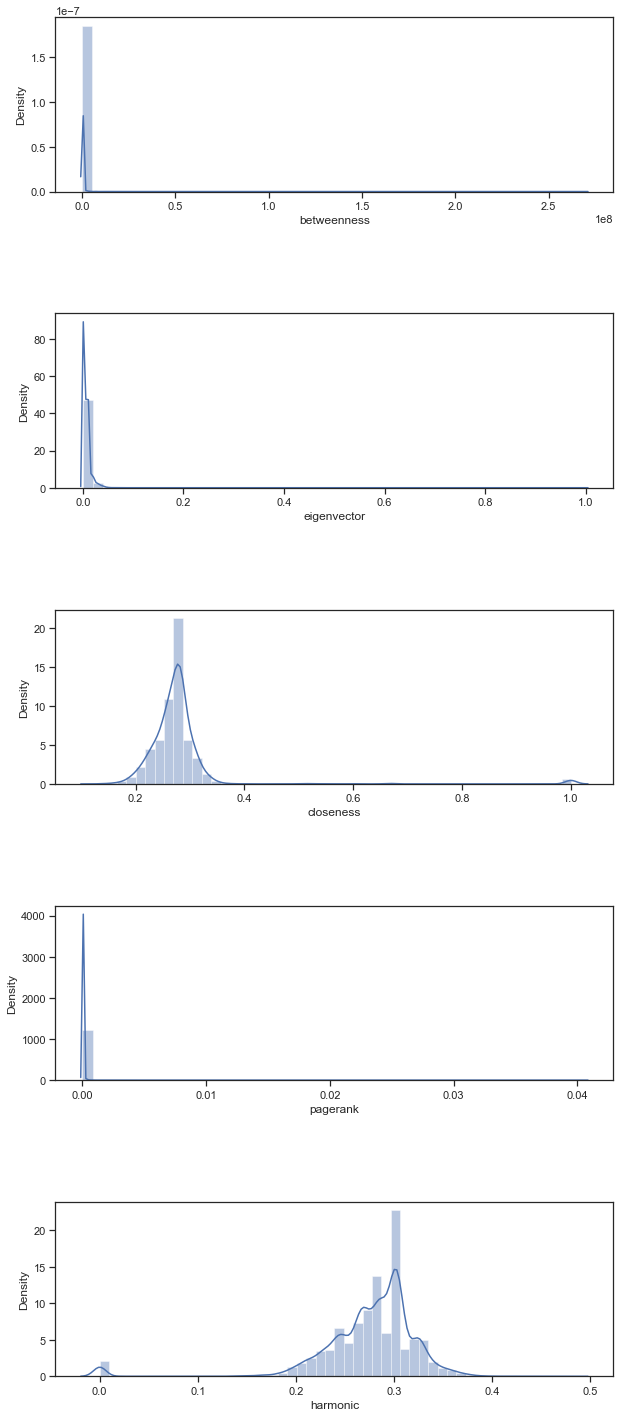

In [ ]:
columns = ['betweenness', 'eigenvector', 'closeness', 'pagerank', 'harmonic']

sns.set(style="ticks")
fig, axes = plt.subplots(5, figsize=(10,25))
fig.subplots_adjust(hspace=.7)

for ax, col in zip(axes, columns):
    sns.distplot(data[col], ax=ax)

En base a los gráficos, puede observarse que las distribuciones para las medidad de centralidad betweenness, eigenvector y pagerank son similares con mayor concentración hacia la izquierda. Harmonica y closseness tienen distribuciones más simétricas con presencia de valores extremos.

Calculamos el top ten de los nodos más centrales.

In [ ]:
columns = ['degree', 'betweenness', 'eigenvector', 'closeness', 'pagerank', 'harmonic']
top_ten = {}
for col in columns:
    top_users = data.nlargest(10, columns=[col])['user'].tolist()
    top_ten[col] = top_users
pd.DataFrame(top_ten)

,degree,betweenness,eigenvector,closeness,pagerank,harmonic
0,252168075,356967138,781671780880613376,131418981,356967138,356967138
1,130979339,781671780880613376,1158274739904950272,88809048,781671780880613376,781671780880613376
2,73102744,1158274739904950272,356967138,4121559077,1158274739904950272,1158274739904950272
3,367933714,901810179876020226,2181250537,918008048,901810179876020226,2181250537
4,593189095,1327797969563889664,923371096975568896,330939282,2181250537,3736470622
5,2687724840,2181250537,901810179876020226,201924584,923371096975568896,1327797969563889664
6,931564592328781824,923371096975568896,230922284,2302883271,2937226749,2974482839
7,144929758,2937226749,2937226749,229516510,1327797969563889664,863463599691444224
8,312708081,230922284,1327797969563889664,581093954,230922284,1356842492415664128
9,1077176953,340962455,881267766447230980,568573021,1298690680945090567,923371096975568896


En la tabla, que muestra el top ten de los nodos más centrales para cada métrica, vemos que para todas las métricas menos closeness y degree se repiten la mayoría de los usuarios.
Para analizar que características tienen los usuarios más centrales y sus tweets, decidimos trabajar con los detallados debajo:
- 252168075
- 130979339
- 73102744

Analizamos que características tienen los tweets de estos tres usuarios

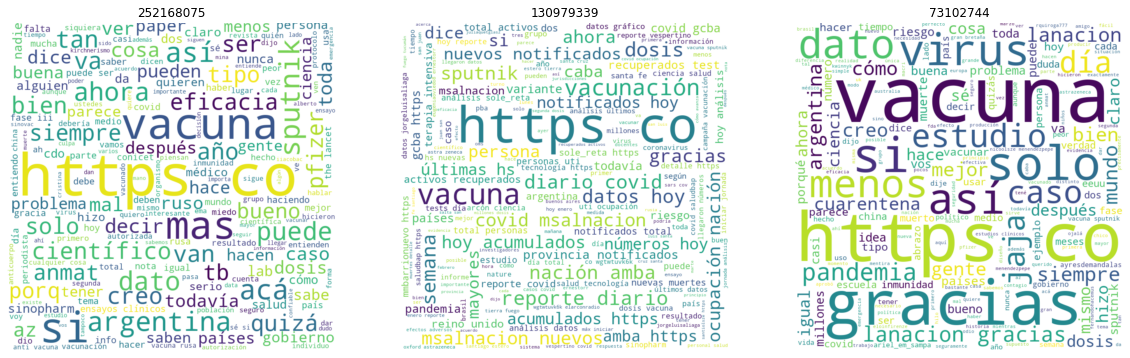

In [10]:
user_text = {}
values = ['252168075', '130979339', '73102744']
stopwords = set(stopwords.words('spanish'))
 
for user in values:
    comment_words = ''
    mains_users = df.loc[df['user.id'] == user]
    # iterate through the csv file
    for val in mains_users['full_text']:
      
        # typecaste each val to string
        val = str(val)
  
        # split the value
        tokens = val.split()
      
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
      
        comment_words += " ".join(tokens) + " "
    user_text.update({user: comment_words})

fig, axes = plt.subplots(1, 3, figsize=(20,50))
for row, (user, tweet) in enumerate(user_text.items()):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          stopwords = stopwords,
                          min_font_size = 10).generate(tweet)
    col = row % 3
    ax = axes[col]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(user)

No se observa una conección directa entre los tweets de los usuarios. Tampoco se puede afirmar que sean de carácter negativo o afirmativo.

Ejercicio Opcional

In [ ]:
df['user.id'].value_counts()

73102744               2195
252168075              1953
130979339              1061
2687724840              893
367933714               782
                       ... 
143601360                 1
842944941621960704        1
205437186                 1
1280677530949779457       1
413602077                 1
Name: user.id, Length: 42237, dtype: int64

Podemos observar que los usuarios que más escriben coinciden con aquellos que tienen mayor centralidad según el degree.

### **3. Comunidades**

Utilizar el algoritmo de Louvain con el parámetro "resolución" igual a 1. Caracterizar las comunidades halladas (cantidad, distribución de tamaños). Utilizar la modularidad y otras dos métricas a elección para evaluar la calidad de la partición encontrada. 

Variar el parámetro "resolución" y observar cómo cambia la distribución de comunidades encontradas. ¿Existe algún valor para el cual se identifiquen dos grandes comunidades?

Elegir otro algoritmo de detección de comunidades y comparar los resultados con los obtenidos anteriormente.

**Opcional:** Correr el algoritmo de Louvain con distintas semillas aleatorias. Utilizar alguna métrica de comparación externa entre las particiones obtenidas para determinar en qué medida depende el algoritmo de la condición inicial.

In [ ]:
# Algunas funciones que vamos a necesitar

def create_contingency_table(comms1, comms2):
    """
    Compute contingency table between partition comms1 and
    partition comms2.
    
    The contingency table is defined by
    
    n_{kk'} = |C_k \cap C'_{k'}|.
    """
    table = np.zeros((len(comms1), len(comms2)))
    for i, c1 in enumerate(comms1):
        for j, c2 in enumerate(comms2):
            table[i,j] = len(set(c1).intersection(c2))
    return table

def mutual_information(comms1, comms2):
    if isinstance(comms1, NodeClustering):
        comms1 = comms1.communities
    if isinstance(comms2, NodeClustering):
        comms2 = comms2.communities
    table = create_contingency_table(comms1, comms2)
    table = table / table.sum()
    MI = 0
    for k1, comm1 in enumerate(comms1):
        for k2, comm2 in enumerate(comms2):
            if table[k1, k2] == 0:
                continue
            pk1 = table.sum(axis=1)[k1]
            pk2 = table.sum(axis=0)[k2]
            if (pk1 == 0) or (pk2 == 0):
                continue
            MI += table[k1, k2] * np.log2(table[k1, k2] / (pk1*pk2))
    return MI

def run_louvain(g, min_res, max_res, samples=10, logspace=True):
    comms_dict = {}
    if logspace:
        resolutions = np.logspace(np.log10(min_res), np.log10(max_res), samples)
    else:
        resolutions = np.linspace(min_res, max_res, samples)
    for resolution in resolutions:
        comms = algorithms.louvain(
            g, weight='weight', resolution=resolution, randomize=False
        )
        comms_dict[resolution] = comms
    return comms_dict

def plot_louvain(g, comms_dict):
    resolutions = comms_dict.keys()
    Q_values = [evaluation.newman_girvan_modularity(g, comms).score for comms in comms_dict.values()]
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_ylabel('Q')
    ax.set_xlabel('Resolution')
    ax.set_xscale('log')
    ax.plot(resolutions, Q_values, '-', label='Louvain')
    ax.legend()
    return ax

Corremos el algoritmo de Louvain con el parámetro "resolución" igual a 1 y vemos la cantidad y distribución de tamaños de las comunidades halladas.

In [ ]:
comms = algorithms.louvain(main_node, weight='weight', resolution=1., randomize=False)

In [ ]:
print("Cantidad de comunidades halladas:", len(comms.communities))

Cantidad de comunidades halladas: 357


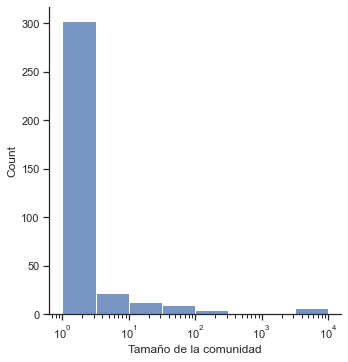

In [ ]:
sns.displot([len(comm) for comm in comms.communities], log_scale=(True, False), binwidth=0.5)
plt.xlabel('Tamaño de la comunidad')
sns.despine()

Calculamos la modularidad, densidad interna y el índice de corte de la partición encontrada

In [ ]:
print('Comunidades encontradas:', evaluation.newman_girvan_modularity(main_node, comms))

Comunidades encontradas: FitnessResult(min=None, max=None, score=0.5652539397576266, std=None)


In [ ]:
print('Comunidades encontradas:', evaluation.internal_edge_density(main_node, comms))

Comunidades encontradas: FitnessResult(min=0, max=2.0, score=0.705687285002685, std=0.45583682634638145)


In [ ]:
print('Comunidades encontradas:', evaluation.cut_ratio(main_node, comms))

Comunidades encontradas: FitnessResult(min=0.0, max=4.398311048557354e-05, score=2.1662258829522452e-06, std=7.272601831842922e-06)


Ahora variamos el parámetro "resolución" y observamos como varía la modularidad

In [ ]:
comms_dict = run_louvain(main_node, 0.1, 10)

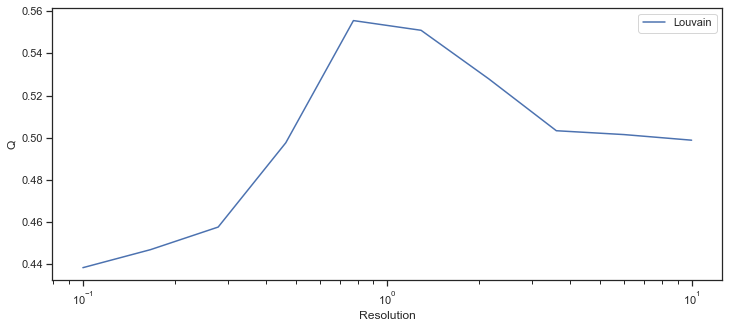

In [ ]:
ax_louvain = plot_louvain(main_node, comms_dict)

In [ ]:
comm_stats = []
for i, (resolution, comms) in enumerate(comms_dict.items()):
    count = [len(comm) for comm in comms.communities]
    comm_stats.append([resolution.round(2), count[:5], round(100*(sum(count[:2])/len(main_node.nodes)),2)])
df_comm_stats =  pd.DataFrame(comm_stats, columns=['resolution', 'top-5 comms', 'percentage of top-2'])
df_comm_stats

,resolution,top-5 comms,percentage of top-2
0,0.10,"[3018, 2696, 2223, 2114, 1809]",14.36
1,0.17,"[3028, 2741, 2251, 2130, 1850]",14.49
2,0.28,"[3082, 2761, 2259, 2145, 1868]",14.68
3,0.46,"[3195, 2902, 2420, 2377, 2364]",15.32
4,0.77,"[6303, 5838, 4204, 3499, 3430]",30.51
5,1.29,"[15468, 14540, 3223, 3171, 613]",75.40
6,2.15,"[19455, 15510, 3080, 190, 138]",87.85
7,3.59,"[22587, 15702, 188, 106, 85]",96.20
8,5.99,"[22691, 15801, 188, 106, 91]",96.71
9,10.00,"[22862, 15848, 120, 106, 71]",97.26


Al variar el parámetro "resolución" podemos observar como cambia la distribución de las comunidades y que a partir de una resolución=3.59 se identifican 2 grandes comunidades que nuclean más del 96% de los nodos. Guardamos las comunidades generadas con esa resolución para los puntos siguientes.

In [ ]:
comunidades = algorithms.louvain(main_node, weight='weight', resolution=3.59, randomize=False)

Ahora realizamos los mismos pasos para el algoritmo de label propagation. Este método no tiene parámetros para variar, con lo cual obtenemos una sola partición posible.

In [ ]:
comms2 = algorithms.label_propagation(main_node)

In [ ]:
print("Cantidad de comunidades halladas:", len(comms2.communities), "(aprox. tres veces más que la cantidad obtenida con Louvain)")

Cantidad de comunidades halladas: 995 (aprox. tres veces más que la cantidad obtenida con Louvain)


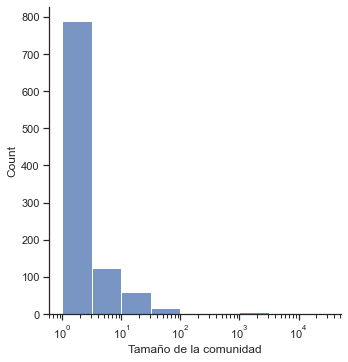

In [ ]:
sns.displot([len(comm) for comm in comms2.communities], log_scale=(True, False), binwidth=0.5)
plt.xlabel('Tamaño de la comunidad')
sns.despine()

In [ ]:
print('Comunidades encontradas:', evaluation.newman_girvan_modularity(main_node, comms2))

Comunidades encontradas: FitnessResult(min=None, max=None, score=0.5400785017472287, std=None)


In [ ]:
print('Comunidades encontradas:', evaluation.internal_edge_density(main_node, comms2))

Comunidades encontradas: FitnessResult(min=0, max=2.0, score=0.7309977455067207, std=0.4110193431146308)


In [ ]:
print('Comunidades encontradas:', evaluation.cut_ratio(main_node, comms2))

Comunidades encontradas: FitnessResult(min=0.0, max=0.00010050503781502048, score=1.4469825516989787e-05, std=1.4153646269434394e-05)


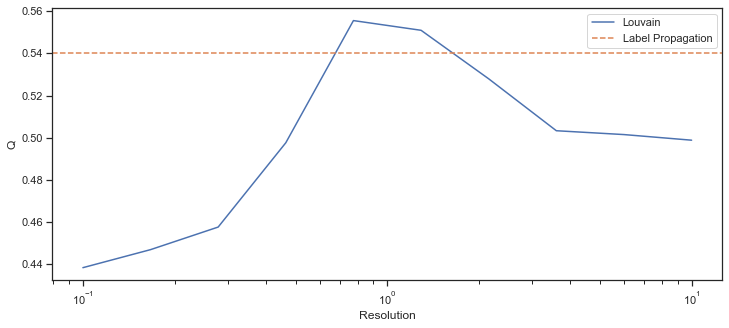

In [ ]:
# Graficamos la modularidad para distintos valores de resolución con el algoritmo Louvain y 
#marcamos la obtenidad con el algoritmo de label propagation
Q_label = evaluation.newman_girvan_modularity(main_node, algorithms.label_propagation(main_node)).score
ax = plot_louvain(main_node, comms_dict);
ax.axhline(Q_label, linestyle='--', label='Label Propagation', color='C1')
ax.legend();

In [ ]:
count2 = [len(comm) for comm in comms2.communities]
comm_stats2 = [count2[:5], round(100*(sum(count2[:2])/len(main_node.nodes)),2)]
df_comm_stats2 = pd.DataFrame(data=[comm_stats2], columns=['top-5 comms', 'percentage of top-2'])
df_comm_stats2

,top-5 comms,percentage of top-2
0,"[14912, 9519, 2947, 2712, 2176]",61.38


Como se puede observar, el porcentaje del total de nodos que representan las dos comunidades más grandes halladas con label propagation (61%) es mucho menor que las que habiamos hallado con Louvain (96%) Por lo tanto, las comunidades encontradas con Louvain son las que utilizaremos para los puntos 4 y 5.

### **4. Extracción de etiquetas**
En el archivo etiquetas.csv están las etiquetas para un pequeño subconjunto de nodos. Podemos interpretar el valor de la etiqueta como la pertenencia a una determinada clase, donde los usuarios de una misma clase en general tienden a expresar apoyo entre sí.

Determinar quiénes son los usuarios referentes de cada clase (utilizar alguna medida de centralidad calculada sobre el grafo de retweets).
Utiliando los resultados del práctico anterior, determinar si los usuarios de cada clase forman parte de distintas comunidades.
Opcional: Reconstruir el archivo "etiquetas.csv". Para eso, hacer lo siguiente

Construir un grafo en donde los nodos sean usuarios, y donde los enlaces unan dos nodos si entre ellos hubo más respuestas de apoyo que de oposición.
Extraer las dos componentes más grandes del grafo. Esos serán nuestros nodos etiquetados

In [ ]:
dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}

#DATA_DIR = Path('/content/drive/MyDrive/GraphMachineLearning/notebooks/data')
DATA_DIR = Path('data')
INPUT_FILE = DATA_DIR / 'etiquetas.csv'

## Creamos el directorio en caso de que no exista
DATA_DIR.mkdir(parents=True, exist_ok=True)

df_etiquetas = pd.read_csv(INPUT_FILE, dtype=dtypes)
df_etiquetas= df_etiquetas.rename(columns={'user.id':'user'})

In [ ]:
df_etiquetas.head()

,user,Clase
0,1227432088925851650,0
1,1148843472,0
2,1329815581302853632,0
3,131669966,0
4,811607948,0


Determinamos la cantidad de user por clase.

In [ ]:
df_etiquetas.Clase.value_counts()

0    107
1     89
Name: Clase, dtype: int64

In [ ]:
df_etiquetas = pd.merge(df_etiquetas, data, on='user',how='left')
df_etiquetas= df_etiquetas.dropna()

In [ ]:
df_etiquetas.Clase.value_counts()

0    84
1    68
Name: Clase, dtype: int64

**Usuarios referentes de cada clase**

In [ ]:
#Top para clase 0
columns=['degree', 'betweenness', 'eigenvector', 'closeness', 'pagerank', 'harmonic']
dataRef = {}
for col in columns:
    top_users = df_etiquetas[df_etiquetas['Clase'] == 0].nlargest(5, columns=[col])['user'].tolist()
    dataRef[col] = top_users
pd.DataFrame(dataRef)

,degree,betweenness,eigenvector,closeness,pagerank,harmonic
0,252168075,70596691,811960507829800960,811960507829800960,70596691,811960507829800960
1,510740590,811960507829800960,542672934,542672934,811960507829800960,542672934
2,145493922,542672934,1180936849,1180936849,484349869,1180936849
3,484349869,1340629915176226825,2229279600,2229279600,510740590,2229279600
4,43814969,35961319,2407572261,202984292,542672934,4470440536


Podemos detectar que el usuario 252168075, correspondiente a Norabar, que había sido seleccionado en el top10 anteriormente, también se encuentra en como principal influencer de la clase 0.

In [ ]:
#Top para clase 1
columns=['degree', 'betweenness', 'eigenvector', 'closeness', 'pagerank', 'harmonic']
dataRef1 = {}
for col in columns:
    top_users = df_etiquetas[df_etiquetas['Clase'] == 1].nlargest(5, columns=[col])['user'].tolist()
    dataRef1[col] = top_users
pd.DataFrame(dataRef1)

,degree,betweenness,eigenvector,closeness,pagerank,harmonic
0,73102744,867223140,867223140,867223140,867223140,867223140
1,367933714,73102744,26952449,1954572703,73102744,73102744
2,2687724840,770043118435598337,341154704,73102744,770043118435598337,26952449
3,3421061763,990727302114930688,1169225200740831233,983848121754058752,1351621913446141953,983848121754058752
4,4160782817,33524608,983848121754058752,26952449,146631761,1954572703


Podemos detectar que el usuario 73102744, correspondiente a Ernestorr, que había sido seleccionado en el top10 del punto anteriormente, también se encuentra en como principal influencer de la clase 1.

**Utilizando los resultados del práctico anterior, determinar si los usuarios de cada clase forman parte de distintas comunidades**

In [ ]:
comunidad_1 = list(comunidades.communities[0])
comunidad_2 = list(comunidades.communities[1])

In [ ]:
clase_0 = list(df_etiquetas[df_etiquetas['Clase'] == 0]['user'])
clase_1 = list(df_etiquetas[df_etiquetas['Clase'] == 1]['user'])

In [ ]:
#Cantidad de usuarios de la clase 0 que se encuentran en la comunidad 1
total_clase_0_1 = len([x for x in clase_0 if x in comunidad_1])
print("Cantidad de usuarios de la clase 0 que se encuentran en la comunidad 1 es:", total_clase_0_1)

Cantidad de usuarios de la clase 0 que se encuentran en la comunidad 1 es: 0


In [ ]:
#Cantidad de usuarios de la clase 0 que se encuentran en la comunidad 2
total_clase_0_2 = len([x for x in clase_0 if x in comunidad_2])
print("Cantidad de usuarios de la clase 0 que se encuentran en la comunidad 2 es:", total_clase_0_2)

Cantidad de usuarios de la clase 0 que se encuentran en la comunidad 2 es: 84


In [ ]:
#Cantidad de usuarios de la clase 1 que se encuentran en la comunidad 1
total_clase_1_1 = len([x for x in clase_1 if x in comunidad_1])
print("Cantidad de usuarios de la clase 1 que se encuentran en la comunidad 1 es:", total_clase_1_1)

Cantidad de usuarios de la clase 1 que se encuentran en la comunidad 1 es: 67


In [ ]:
#Cantidad de usuarios de la clase 1 que se encuentran en la comunidad 1
total_clase_1_2 = len([x for x in clase_1 if x in comunidad_2])
print("Cantidad de usuarios de la clase 1 que se encuentran en la comunidad 2 es:", total_clase_1_2)

Cantidad de usuarios de la clase 1 que se encuentran en la comunidad 2 es: 1


La clase 0 parece corresponder a la comunidad 2, mientras que la clase 1 correspondería a la comunidad 1.

In [ ]:
# No nos andaba cdlib en colab asi que generamos los resultados con jupyter y los cargamos si usamos colab para usar en el punto 5

#Exportamos df_etiquetas para punto 5
df_etiquetas.to_csv('resultados_etiqueta.csv')
#Exportamos 2 principales comunidades para punto 5
comuni_1 = pd.DataFrame(comunidad_1).rename(columns={0:'comunidad_1'})
comuni_1.to_csv('comm_1.csv')
comuni_2 = pd.DataFrame(comunidad_2).rename(columns={0:'comunidad_2'})
comuni_2.to_csv('comm_2.csv')

In [ ]:
#DATA_DIR = Path('/content/drive/MyDrive/GraphMachineLearning/notebooks/')
#INPUT_FILE = DATA_DIR / 'comm_1.csv'
#comuni_1 = pd.read_csv(INPUT_FILE, dtype=dtypes)

#DATA_DIR = Path('/content/drive/MyDrive/GraphMachineLearning/notebooks/')
#INPUT_FILE = DATA_DIR / 'comm_2.csv'
#comuni_2 = pd.read_csv(INPUT_FILE, dtype=dtypes)

### **5. Embedding de nodos**
Generar un embedding del grafo de retweets utilizando el algoritmo word2vec.
Reducir a 2 la dimensionalidad del embedding utilizando PCA y t-SNE.
Graficar los embeddings correspondientes a los datos etiquetados. ¿Es posible diferenciar unos de otros?
Opcional: Graficar además los embeddings de los nodos que forman parte de las comunidades asociadas a cada clase. Determinar si el embedding permite distinguir cada comunidad.

In [ ]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 5.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 5.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.3 MB 5.1 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 747 kB 5.2 MB/s 
     |████████████████████████████████| 325 kB 5.2 MB/s 
     |████████████████████████████████| 407 kB 43.0 MB/s 
     |████████████████████████████████| 45 kB 3.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=2b2141a06f68af2385fbadf187f62029aee9530e8f578eef9a76de1fc784a854
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built to

In [ ]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


Generamos las Matrices esparsas

In [ ]:
adj = nx.to_scipy_sparse_matrix(main_node).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)
print(edge_index.shape)

torch.Size([2, 186464])


Algoritmo Node2Vec

In [ ]:
from torch_geometric.nn import Node2Vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

## Definimos nuestro modelo
model = Node2Vec(
    edge_index, embedding_dim=100, walk_length=10, 
    context_size=4, num_negative_samples=5
).to(device)

## El loader es un wrapper que nos permite trabajar por lotes, 
## para utilizar descenso por el gradiente estocástico y
## sus variantes
loader = model.loader(batch_size=128, shuffle=True)

## Optimizador
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)

In [ ]:
def train():
    ## Ponemos nuestro modelo en modo entrenamiento
    model.train()

    total_loss = 0
    for pos_rw, neg_rw in loader:

        ## Reseteamos los gradientes
        optimizer.zero_grad()

        ## Calculamos el error (la función de costo) del lote
        ## en función de los samples positivos y negativos
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))

        ## Hacemos backpropagation
        loss.backward()

        ## Avanzamos un paso
        optimizer.step()

        ## Actualizamos la función de costo total
        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
epochs = 25
for epoch in range(epochs):
    loss = train()
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3} - Loss: {loss:.3f}')

Epoch:   0 - Loss: 6.445
Epoch:   5 - Loss: 1.680
Epoch:  10 - Loss: 0.974
Epoch:  15 - Loss: 0.888
Epoch:  20 - Loss: 0.882


In [ ]:
def get_embedding():
    model.eval()
    with torch.no_grad():
        nodes = torch.arange(main_node.number_of_nodes(), device=device)
        embedding = model(nodes).detach().numpy()
    return embedding

embedding = get_embedding()

In [ ]:
pca = PCA(n_components=2, random_state=22).fit_transform(embedding)

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=22).fit_transform(embedding)

In [ ]:
etiquetas_0 = [i for i, v in enumerate(main_node.nodes()) if v in (list(df_etiquetas[df_etiquetas['Clase']==0]['user']))]
etiquetas_1 = [i for i, v in enumerate(main_node.nodes()) if v in (list(df_etiquetas[df_etiquetas['Clase']==1]['user']))]

comunid_1 = [i for i, v in enumerate(main_node.nodes()) if v in [str(x) for x in list(comuni_1['comunidad_1'])]] 
comunid_2 = [i for i, v in enumerate(main_node.nodes()) if v in [str(x) for x in list(comuni_2['comunidad_2'])]] 

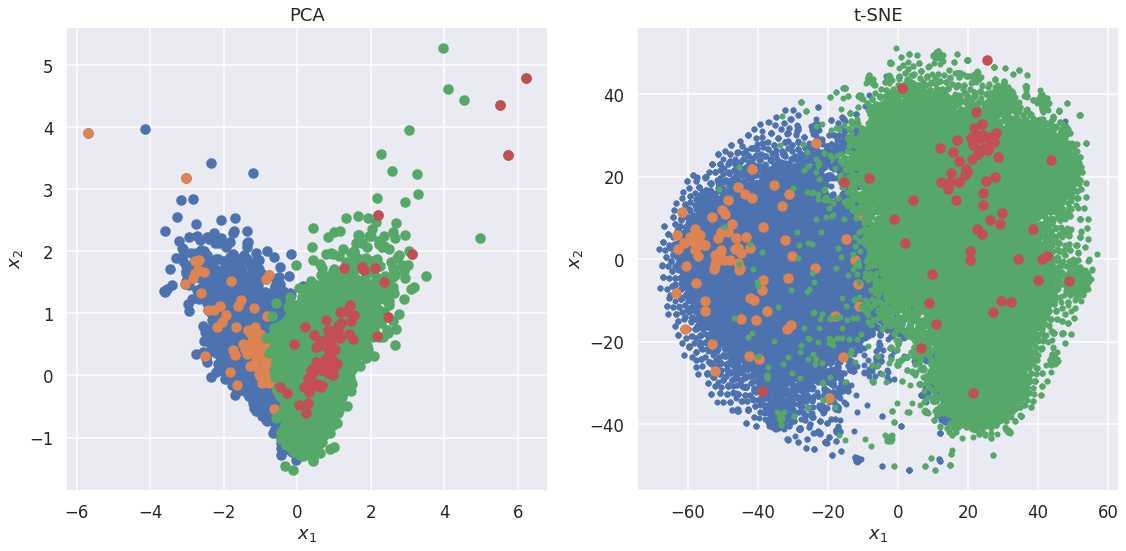

In [ ]:
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols, 8), ncols=2)
ax = axes[0]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('PCA')
ax.scatter(pca[comunid_2][:,0],pca[comunid_2][:,1], c='C0')
ax.scatter(pca[etiquetas_0][:,0],pca[etiquetas_0][:,1], c='C1')
ax.scatter(pca[comunid_1][:,0],pca[comunid_1][:,1], c='C2')
ax.scatter(pca[etiquetas_1][:,0],pca[etiquetas_1][:,1], c='C3')

ax = axes[1]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('t-SNE')
ax.scatter(tsne[comunid_2][:,0],tsne[comunid_2][:,1], c='C0', marker='.')
x, y = tsne[etiquetas_0][:,0],tsne[etiquetas_0][:,1]
ax.scatter(tsne[etiquetas_0][:,0],tsne[etiquetas_0][:,1],c='C1')
x, y = tsne[comunid_1][:,0],tsne[comunid_1][:,1]
ax.scatter(tsne[comunid_1][:,0],tsne[comunid_1][:,1], c='C2', marker='.')
ax.scatter(tsne[etiquetas_1][:,0],tsne[etiquetas_1][:,1],c='C3')

plt.tight_layout()
plt.show()

Los embeddings separan bastante bien los datos etiquetados y permiten distinguir los nodos que forman parte de las comunidades asociadas a cada clase.